In [1]:
import sys
sys.path.append('../utils')
import mesh_tools as mt
from SDF_CNN import CNN_3d_multiple_split
from CNN_to_PoNQ_or_lite import CNN_to_PoNQ
from ABC_dataset import make_mask_close
import torch
from meshplot import plot
import igl
import matplotlib.pyplot as plt

In [2]:
state_dict = '../../data/pretrained_PoNQ_ABC.pt'
example_mesh = '../../data/bunny.obj'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
grid_n = 33

In [3]:
model = CNN_3d_multiple_split(device=device)
model.load_state_dict(torch.load(state_dict, map_location=device))
model.to(device)
model.eval()

CNN_3d_multiple_split(
  (encoder): Sequential(
    (0): Conv3d(1, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder_points): SDF_decoder(
    (decoder): Sequential(
      (0): resnet_block(
        (conv_1): Conv3d(128, 128, kernel_

In [4]:
v, f = igl.read_triangle_mesh(example_mesh)
v = 2*mt.NDCnormalize(v)

points = mt.mesh_grid(grid_n, True)
sdf = igl.signed_distance(points, v, f)[0].reshape(grid_n, grid_n, grid_n)

tensor_sdf = torch.tensor(sdf, dtype=torch.float32, device=device)[None, None, ...]
tensor_mask = torch.tensor(make_mask_close(sdf, grid_n), dtype=torch.bool, device=device).flatten()[None, ...]

In [5]:
# plot(v,f)

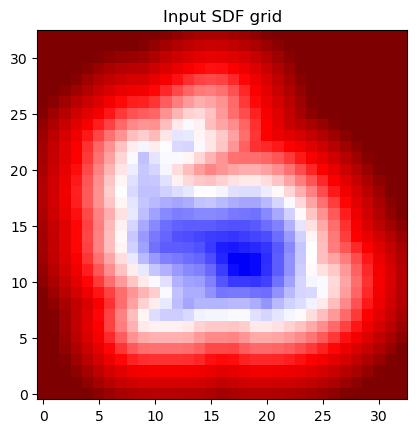

In [6]:
plt.imshow(sdf[:, :, grid_n//2].T, origin='lower', vmin=-.5, vmax=.5, cmap='seismic')
plt.title('Input SDF grid')
plt.show()

In [10]:
print('Marching Cubes reconstruction')
plot(*mt.mesh_from_voxels(sdf))

Marching Cubes reconstruction


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0004573…

In [11]:
ponq = CNN_to_PoNQ(model, tensor_sdf, grid_n, tensor_mask, device=device, subd=0)

In [14]:
print('Quadric visualization (PoNQ prediction)')
plot(*ponq.quadric_ellipse_mesh(size=0.015))

Quadric visualization (PoNQ prediction)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0010178…

In [12]:
print('PoNQ mesh')
plot(*ponq.min_cut_surface(grid_n))

PoNQ mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0008501…